## Preparing data

In [0]:
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder, StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.sql.functions import col
from pyspark.ml import Pipeline
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.feature import IndexToString
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pyspark.sql import functions as F
from itertools import product
from pyspark.ml.functions import vector_to_array
from pyspark.sql.functions import col, sum as _sum, when
import time
from typing import Dict, List, Tuple
from pyspark.ml.feature import FeatureHasher, Imputer


In [0]:
# Mount base directory
data_BASE_DIR = "dbfs:/student-groups/Group_4_1/"
display(dbutils.fs.ls(f"{data_BASE_DIR}"))

path,name,size,modificationTime
dbfs:/student-groups/Group_4_1/08f51b3e-da58-4e4d-9da0-e331eeb9b245/,08f51b3e-da58-4e4d-9da0-e331eeb9b245/,0,1765589573780
dbfs:/student-groups/Group_4_1/3f887a59-7aaf-44bd-ad75-d9ab2e382e22/,3f887a59-7aaf-44bd-ad75-d9ab2e382e22/,0,1765589573780
dbfs:/student-groups/Group_4_1/5Y/,5Y/,0,1765589573780
dbfs:/student-groups/Group_4_1/86b0469f-b9c6-4218-8869-aaeb39753cac/,86b0469f-b9c6-4218-8869-aaeb39753cac/,0,1765589573780
dbfs:/student-groups/Group_4_1/airport_codes.parquet/,airport_codes.parquet/,0,1765589573780
dbfs:/student-groups/Group_4_1/best_preds_final_test_5Y.parquet/,best_preds_final_test_5Y.parquet/,0,1765589573780
dbfs:/student-groups/Group_4_1/c505789c-684a-47b9-84e1-24d52ec7cb99/,c505789c-684a-47b9-84e1-24d52ec7cb99/,0,1765589573780
dbfs:/student-groups/Group_4_1/cv_model/,cv_model/,0,1765589573780
dbfs:/student-groups/Group_4_1/df_test_scaled.parquet/,df_test_scaled.parquet/,0,1765589573780
dbfs:/student-groups/Group_4_1/df_test_scaled_checkpoint.parquet/,df_test_scaled_checkpoint.parquet/,0,1765589573780


In [0]:
# Load 5 year dataset
df_otpw_5y = spark.read.parquet("dbfs:/student-groups/Group_4_1/otpw_5Y_checkpoint_7/")
print("5-year rows:", df_otpw_5y.count(), " / columns:", len(df_otpw_5y.columns))
print("5-year columns:", df_otpw_5y.columns)

5-year rows: 26650801  / columns: 53
5-year columns: ['FL_DATE', 'ORIGIN', 'HourlyPrecipitation', 'HourlySeaLevelPressure', 'DEP_DELAY_GROUP', 'DEP_TIME', 'HourlyWetBulbTemperature', 'HourlyStationPressure', 'HourlyWindSpeed', 'HourlyRelativeHumidity', 'HourlyDewPointTemperature', 'HourlyDryBulbTemperature', 'HourlyVisibility', 'QUARTER', 'day_of_week', 'ORIGIN_AIRPORT_ID', 'DEST_AIRPORT_ID', 'ELEVATION', 'LONGITUDE', 'LATITUDE', 'ts_date', 'DISTANCE_GROUP', 'DISTANCE', 'CRS_ELAPSED_TIME', 'month', 'HourlyAltimeterSetting', 'is_us_holiday', 'is_holiday_window', 'is_summer_peak', 'season', 'is_weekday', 'is_superbowl_window', 'hour_of_day', 'is_weekend', 'is_CES_window', 'is_CES_LasVegas_Peak', 'is_GHC_window', 'is_GHC_Host_Airport_Peak', 'route_avg_delay_last_7days', 'origin_avg_delay_last_7days', 'dest_avg_delay_last_7days', 'Weather_Index', 'HourlySkyConditions', 'CRS_DEP_TIME_SIN', 'CRS_DEP_TIME_COS', 'is_disaster_day', 'days_since_disaster', 'disaster_severity', 'is_disruption_day'

In [0]:
# Function to check nulls for a dataframe
def null_summary(df):
    total_rows = df.count()

    # Compute null count and percentage per column
    null_summary = df.select([
        _sum(when(col(c).isNull(), 1).otherwise(0)).alias(c)
        for c in df.columns
    ]).toPandas().T.reset_index()

    null_summary.columns = ["Column", "Null_Count"] 
    null_summary["Null_%"] = (null_summary["Null_Count"] / total_rows * 100).round(2)

    # Sort by highest missing percentage
    null_summary = null_summary.sort_values(by="Null_%", ascending=False).reset_index(drop=True)

    return null_summary

# Function to select dataframe and columns
def select_df(df, columns):
    return df.select(columns)
    
# Function to create departure delay classification groups
def create_delay_groups(df):
    return df.withColumn(
        'DEP_DELAY_GROUP_CLASSIFIED',
        when(col("DEP_DELAY_GROUP") >= 1, 'delayed')
        .otherwise('not_delayed')
    )

In [0]:
null_summary(df_otpw_5y)

,Column,Null_Count,Null_%
0,FL_DATE,0,0.0
1,ORIGIN,0,0.0
2,HourlyPrecipitation,0,0.0
3,HourlySeaLevelPressure,0,0.0
4,DEP_DELAY_GROUP,0,0.0
5,DEP_TIME,0,0.0
6,HourlyWetBulbTemperature,0,0.0
7,HourlyStationPressure,0,0.0
8,HourlyWindSpeed,0,0.0
9,HourlyRelativeHumidity,0,0.0


In [0]:
# Check sample data
display(df_otpw_5y.limit(5))

FL_DATE,ORIGIN,HourlyPrecipitation,HourlySeaLevelPressure,DEP_DELAY_GROUP,DEP_TIME,HourlyWetBulbTemperature,HourlyStationPressure,HourlyWindSpeed,HourlyRelativeHumidity,HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlyVisibility,QUARTER,day_of_week,ORIGIN_AIRPORT_ID,DEST_AIRPORT_ID,ELEVATION,LONGITUDE,LATITUDE,ts_date,DISTANCE_GROUP,DISTANCE,CRS_ELAPSED_TIME,month,HourlyAltimeterSetting,is_us_holiday,is_holiday_window,is_summer_peak,season,is_weekday,is_superbowl_window,hour_of_day,is_weekend,is_CES_window,is_CES_LasVegas_Peak,is_GHC_window,is_GHC_Host_Airport_Peak,route_avg_delay_last_7days,origin_avg_delay_last_7days,dest_avg_delay_last_7days,Weather_Index,HourlySkyConditions,CRS_DEP_TIME_SIN,CRS_DEP_TIME_COS,is_disaster_day,days_since_disaster,disaster_severity,is_disruption_day,is_airport_disrupted,is_federal_shutdown_day,disruption_severity,days_into_disruption
2018-06-22,MSY,0.0,29.91,0,2008,77.0,29.88,6.0,85.0,75.0,80.0,10.0,2,6,13495,14107,1.2,-90.27751,29.99691,2018-06-22T21:53:00,6,1300.0,190.0,6,29.9,0,0,1,Summer,1,0,0,1,0,0,0,0,15.049128367670365,12.22962516572255,10.724614513185223,-2.446018653388296,clear sky,-0.8767267557075079,0.48098876891938736,1,679,3,0,0,0,0,0
2016-02-13,MSY,0.0,30.35,0,1620,45.0,30.32,0.0,40.0,32.0,56.0,10.0,1,6,13495,14107,1.2,-90.27751,29.99691,2016-02-13T18:53:00,6,1300.0,215.0,2,30.34,0,1,0,Winter,0,0,22,1,0,0,0,0,15.049128367670365,12.22962516572255,10.724614513185223,1.420060848243429,clear sky,-0.9063077870366497,-0.42261826174069994,1,-181,3,0,0,0,0,0
2015-06-02,MSY,0.0,29.92,5,1910,68.0,29.89,5.0,41.0,58.0,84.0,10.0,2,2,13495,14107,1.2,-90.27751,29.99691,2015-06-02T18:53:00,6,1300.0,210.0,6,29.91,0,0,1,Summer,1,0,22,0,0,0,0,0,15.049128367670365,12.22962516572255,10.724614513185223,-1.5220995286837047,partly cloudy,-0.9990482215818578,-0.04361938736533613,1,-437,3,0,0,0,0,0
2015-10-10,MSY,0.0,29.99,-1,1458,68.0,29.96,5.0,58.0,62.0,78.0,10.0,4,6,13495,14107,1.2,-90.27751,29.99691,2015-10-10T16:53:00,6,1300.0,210.0,10,29.98,0,0,0,Fall,0,0,20,1,0,0,0,0,15.049128367670365,12.22962516572255,10.724614513185223,-1.4556678763332909,partly cloudy,-0.7071067811865475,-0.7071067811865477,1,-307,3,0,0,0,0,0
2016-04-09,MSY,0.0,30.25,0,933,55.0,30.22,7.0,23.0,35.0,76.0,10.0,2,6,13495,14107,1.2,-90.27751,29.99691,2016-04-09T10:53:00,6,1300.0,210.0,4,30.24,0,0,0,Spring,0,0,14,1,0,0,0,0,15.049128367670365,12.22962516572255,10.724614513185223,0.38192858067498103,cloudy,0.6259234721840592,-0.7798844830928816,1,-125,3,0,0,0,0,0


In [0]:
# Select columns to keep
selected_columns = ['FL_DATE', 'HourlyPrecipitation', 'HourlySeaLevelPressure', 'DEP_DELAY_GROUP', 'HourlyWetBulbTemperature', 'HourlyStationPressure', 'HourlyWindSpeed', 'HourlyRelativeHumidity', 'HourlyDewPointTemperature', 'HourlyDryBulbTemperature', 'HourlyVisibility', 'QUARTER', 'day_of_week', 'ORIGIN_AIRPORT_ID', 'DEST_AIRPORT_ID', 'ELEVATION', 'LONGITUDE', 'LATITUDE', 'DISTANCE_GROUP', 'DISTANCE', 'month', 'HourlyAltimeterSetting', 'is_us_holiday', 'is_holiday_window', 'is_summer_peak', 'season', 'is_weekday', 'is_superbowl_window', 'hour_of_day', 'is_weekend', 'is_CES_window', 'is_CES_LasVegas_Peak', 'is_GHC_window', 'is_GHC_Host_Airport_Peak', 'route_avg_delay_last_7days', 'origin_avg_delay_last_7days', 'dest_avg_delay_last_7days', 'Weather_Index', 'HourlySkyConditions', 'CRS_DEP_TIME_SIN', 'CRS_DEP_TIME_COS', 'is_disaster_day', 'days_since_disaster', 'disaster_severity', 'is_disruption_day', 'is_airport_disrupted', 'is_federal_shutdown_day', 'disruption_severity', 'days_into_disruption']

In [0]:
# Create delay groups
df_5y = select_df(df_otpw_5y, selected_columns)
df_5y = create_delay_groups(df_5y)

In [0]:
# Create year column, derive from FL_DATE
df_5y = df_5y.withColumn("YEAR", F.year("FL_DATE"))
df_5y.select("FL_DATE", "YEAR").show(10, truncate=False)

+----------+----+
|FL_DATE   |YEAR|
+----------+----+
|2018-06-22|2018|
|2016-02-13|2016|
|2015-06-02|2015|
|2015-10-10|2015|
|2016-04-09|2016|
|2016-10-03|2016|
|2017-07-11|2017|
|2017-05-17|2017|
|2019-03-30|2019|
|2018-07-19|2018|
+----------+----+
only showing top 10 rows


In [0]:
# Check columns schema
df_5y.printSchema()

root
 |-- FL_DATE: date (nullable = true)
 |-- HourlyPrecipitation: double (nullable = true)
 |-- HourlySeaLevelPressure: double (nullable = true)
 |-- DEP_DELAY_GROUP: string (nullable = true)
 |-- HourlyWetBulbTemperature: double (nullable = true)
 |-- HourlyStationPressure: double (nullable = true)
 |-- HourlyWindSpeed: double (nullable = true)
 |-- HourlyRelativeHumidity: double (nullable = true)
 |-- HourlyDewPointTemperature: double (nullable = true)
 |-- HourlyDryBulbTemperature: double (nullable = true)
 |-- HourlyVisibility: double (nullable = true)
 |-- QUARTER: string (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- ORIGIN_AIRPORT_ID: string (nullable = true)
 |-- DEST_AIRPORT_ID: string (nullable = true)
 |-- ELEVATION: string (nullable = true)
 |-- LONGITUDE: string (nullable = true)
 |-- LATITUDE: string (nullable = true)
 |-- DISTANCE_GROUP: string (nullable = true)
 |-- DISTANCE: string (nullable = true)
 |-- month: integer (nullable = true)
 |-- Hourl

In [0]:
# Cast numeric-like categoricals to doubles
to_cast_numeric = ["ELEVATION", "LATITUDE", "LONGITUDE", "DISTANCE"]
for c in to_cast_numeric:
    df_5y = df_5y.withColumn(c, F.col(c).cast("double"))
# Drop FL_DATE
df_5y = df_5y.drop("FL_DATE")

In [0]:
# Check null values again
print(null_summary(df_5y))
# Check sample data
display(df_5y.limit(5))

                         Column  Null_Count  Null_%
0           HourlyPrecipitation           0     0.0
1        HourlySeaLevelPressure           0     0.0
2               DEP_DELAY_GROUP           0     0.0
3      HourlyWetBulbTemperature           0     0.0
4         HourlyStationPressure           0     0.0
5               HourlyWindSpeed           0     0.0
6        HourlyRelativeHumidity           0     0.0
7     HourlyDewPointTemperature           0     0.0
8      HourlyDryBulbTemperature           0     0.0
9              HourlyVisibility           0     0.0
10                      QUARTER           0     0.0
11                  day_of_week           0     0.0
12            ORIGIN_AIRPORT_ID           0     0.0
13              DEST_AIRPORT_ID           0     0.0
14                    ELEVATION           0     0.0
15                    LONGITUDE           0     0.0
16                     LATITUDE           0     0.0
17               DISTANCE_GROUP           0     0.0
18          

HourlyPrecipitation,HourlySeaLevelPressure,DEP_DELAY_GROUP,HourlyWetBulbTemperature,HourlyStationPressure,HourlyWindSpeed,HourlyRelativeHumidity,HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlyVisibility,QUARTER,day_of_week,ORIGIN_AIRPORT_ID,DEST_AIRPORT_ID,ELEVATION,LONGITUDE,LATITUDE,DISTANCE_GROUP,DISTANCE,month,HourlyAltimeterSetting,is_us_holiday,is_holiday_window,is_summer_peak,season,is_weekday,is_superbowl_window,hour_of_day,is_weekend,is_CES_window,is_CES_LasVegas_Peak,is_GHC_window,is_GHC_Host_Airport_Peak,route_avg_delay_last_7days,origin_avg_delay_last_7days,dest_avg_delay_last_7days,Weather_Index,HourlySkyConditions,CRS_DEP_TIME_SIN,CRS_DEP_TIME_COS,is_disaster_day,days_since_disaster,disaster_severity,is_disruption_day,is_airport_disrupted,is_federal_shutdown_day,disruption_severity,days_into_disruption,DEP_DELAY_GROUP_CLASSIFIED,YEAR
0.0,29.91,0,77.0,29.88,6.0,85.0,75.0,80.0,10.0,2,6,13495,14107,1.2,-90.27751,29.99691,6,1300.0,6,29.9,0,0,1,Summer,1,0,0,1,0,0,0,0,15.049128367670365,12.22962516572255,10.724614513185223,-2.446018653388296,clear sky,-0.8767267557075079,0.48098876891938736,1,679,3,0,0,0,0,0,not_delayed,2018
0.0,30.35,0,45.0,30.32,0.0,40.0,32.0,56.0,10.0,1,6,13495,14107,1.2,-90.27751,29.99691,6,1300.0,2,30.34,0,1,0,Winter,0,0,22,1,0,0,0,0,15.049128367670365,12.22962516572255,10.724614513185223,1.420060848243429,clear sky,-0.9063077870366497,-0.42261826174069994,1,-181,3,0,0,0,0,0,not_delayed,2016
0.0,29.92,5,68.0,29.89,5.0,41.0,58.0,84.0,10.0,2,2,13495,14107,1.2,-90.27751,29.99691,6,1300.0,6,29.91,0,0,1,Summer,1,0,22,0,0,0,0,0,15.049128367670365,12.22962516572255,10.724614513185223,-1.5220995286837047,partly cloudy,-0.9990482215818578,-0.04361938736533613,1,-437,3,0,0,0,0,0,delayed,2015
0.0,29.99,-1,68.0,29.96,5.0,58.0,62.0,78.0,10.0,4,6,13495,14107,1.2,-90.27751,29.99691,6,1300.0,10,29.98,0,0,0,Fall,0,0,20,1,0,0,0,0,15.049128367670365,12.22962516572255,10.724614513185223,-1.4556678763332909,partly cloudy,-0.7071067811865475,-0.7071067811865477,1,-307,3,0,0,0,0,0,not_delayed,2015
0.0,30.25,0,55.0,30.22,7.0,23.0,35.0,76.0,10.0,2,6,13495,14107,1.2,-90.27751,29.99691,6,1300.0,4,30.24,0,0,0,Spring,0,0,14,1,0,0,0,0,15.049128367670365,12.22962516572255,10.724614513185223,0.38192858067498103,cloudy,0.6259234721840592,-0.7798844830928816,1,-125,3,0,0,0,0,0,not_delayed,2016


## Building baseline model - logistic regression

In [0]:
# Identify numeric feature columns (baseline: numeric only, no extra encoding)
label_col = "DEP_DELAY_GROUP_CLASSIFIED"
leakage_cols = {"DEP_DELAY_GROUP"}
year_col  = "YEAR"
# Split train and test data
train_df_all = df_5y.filter((col(year_col) >= 2015) & (col(year_col) <= 2018))
test_2019_df = df_5y.filter(col(year_col) == 2019)
numeric_cols = [
    c for c, t in df_5y.dtypes
    if t in ("int","bigint","double","float") and (c != label_col) and (c not in leakage_cols)
]
categorical_cols = [c for c, t in df_5y.dtypes if (t == "string") and (c != label_col) and (c not in leakage_cols)]
print("Numeric features:", numeric_cols)
print("Categorical (one-hot):", categorical_cols)

Numeric features: ['HourlyPrecipitation', 'HourlySeaLevelPressure', 'HourlyWetBulbTemperature', 'HourlyStationPressure', 'HourlyWindSpeed', 'HourlyRelativeHumidity', 'HourlyDewPointTemperature', 'HourlyDryBulbTemperature', 'HourlyVisibility', 'day_of_week', 'ELEVATION', 'LONGITUDE', 'LATITUDE', 'DISTANCE', 'month', 'HourlyAltimeterSetting', 'is_us_holiday', 'is_holiday_window', 'is_summer_peak', 'is_weekday', 'is_superbowl_window', 'hour_of_day', 'is_weekend', 'is_CES_window', 'is_CES_LasVegas_Peak', 'is_GHC_window', 'is_GHC_Host_Airport_Peak', 'route_avg_delay_last_7days', 'origin_avg_delay_last_7days', 'dest_avg_delay_last_7days', 'Weather_Index', 'CRS_DEP_TIME_SIN', 'CRS_DEP_TIME_COS', 'is_disaster_day', 'days_since_disaster', 'disaster_severity', 'is_disruption_day', 'is_airport_disrupted', 'is_federal_shutdown_day', 'disruption_severity', 'days_into_disruption', 'YEAR']
Categorical (one-hot): ['QUARTER', 'ORIGIN_AIRPORT_ID', 'DEST_AIRPORT_ID', 'DISTANCE_GROUP', 'season', 'HourlySk

In [0]:
def build_lr_pipeline_binary(
    label_col,
    numeric_cols,
    vector_cols=None,
    categorical_cols=None,
    weight_col=None,
    regParam=0.0,
    elasticNetParam=0.0
):
    """
    Binary logistic regression pipeline:
      - StringIndexer on label
      - StringIndexer + OneHotEncoder on categoricals
      - VectorAssembler over numeric + vector + one-hot
      - LogisticRegression (optionally with weightCol)
    """
    if vector_cols is None:
        vector_cols = []
    if categorical_cols is None:
        categorical_cols = []

    stages = []

    # label string -> index (0/1)
    label_indexer = StringIndexer(
        inputCol=label_col,
        outputCol="label",
        handleInvalid="keep"
    )
    stages.append(label_indexer)

    # index + OHE for categoricals
    cat_indexers = [
        StringIndexer(inputCol=c, outputCol=f"{c}__idx", handleInvalid="keep")
        for c in categorical_cols
    ]
    stages.extend(cat_indexers)

    if categorical_cols:
        ohe = OneHotEncoder(
            inputCols=[f"{c}__idx" for c in categorical_cols],
            outputCols=[f"{c}__oh"  for c in categorical_cols],
            handleInvalid="keep"
        )
        stages.append(ohe)
        ohe_cols = [f"{c}__oh" for c in categorical_cols]
    else:
        ohe_cols = []

    assembler_inputs = numeric_cols + vector_cols + ohe_cols

    assembler = VectorAssembler(
        inputCols=assembler_inputs,
        outputCol="features",
        handleInvalid="skip"
    )
    stages.append(assembler)

    lr = LogisticRegression(
        featuresCol="features",
        labelCol="label",
        predictionCol="prediction",
        probabilityCol="probability",
        rawPredictionCol="rawPrediction",
        maxIter=50,
        regParam=regParam,
        elasticNetParam=elasticNetParam
    )
    if weight_col is not None:
        lr = lr.setWeightCol(weight_col)

    stages.append(lr)

    return Pipeline(stages=stages)

In [0]:
def add_class_weights(df, label_col, alpha=1.0):
    """
    Compute inverse-frequency class weights (to the power alpha)
    on df for label_col, and return df with a new column 'class_weight'.
    """
    counts = df.groupBy(label_col).count().withColumnRenamed("count", "cnt").collect()
    total = sum(r["cnt"] for r in counts)
    k = len(counts)

    # python dict just for printing
    weights_py = {}
    mapping_pairs = []
    for r in counts:
        label_val = r[label_col]
        base_w = float(total) / (k * float(r["cnt"]))   # inverse frequency
        w = base_w ** float(alpha)
        weights_py[label_val] = w
        mapping_pairs.extend([F.lit(label_val), F.lit(w)])

    print(f"Class weights for alpha={alpha}:", weights_py)

    mapping = F.create_map(*mapping_pairs)
    df_with_w = df.withColumn("class_weight", mapping[F.col(label_col)])
    return df_with_w

In [0]:
import time
from itertools import product
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql import functions as F

def grid_search_lr_5y_by_recall(
    df,
    year_col="YEAR",
    label_col="DEP_DELAY_GROUP_CLASSIFIED",
    numeric_cols=None,
    vector_cols=None,
    categorical_cols=None,
    train_years=(2015, 2016, 2017, 2018),
    alphas=(0.5, 1.0),
    regParams=(0.0, 1e-3, 1e-2),
    elasticNetParams=(0.0, 0.5)
):
    """
    Time-based CV grid search for binary LR on 5-year data:

      Train years: 2015–2018
      Folds:
        - Fold 1: train 2015,          validate 2016
        - Fold 2: train 2015–2016,     validate 2017
        - Fold 3: train 2015–2017,     validate 2018

    Selects best config by mean recall for 'delayed'.
    """

    # Restrict to training years
    train_df_all = df.filter(
        (F.col(year_col) >= min(train_years)) & (F.col(year_col) <= max(train_years))
    )

    # Infer feature lists if not provided
    if numeric_cols is None:
        numeric_cols = [
            c for c, t in train_df_all.dtypes
            if t in ("int", "bigint", "double", "float")
            and c != label_col
            and c != "DEP_DELAY_GROUP"
        ]

    if vector_cols is None:
        vector_cols = [c for c, t in train_df_all.dtypes if t == "vector"]

    if categorical_cols is None:
        categorical_cols = [
            c for c, t in train_df_all.dtypes
            if t == "string" and c != label_col and c != "DEP_DELAY_GROUP"
        ]

    print("Using numeric_cols:", numeric_cols)
    print("Using vector_cols:", vector_cols)
    print("Using categorical_cols:", categorical_cols)

    # Predefine folds by year
    folds_def = [
        ([2015],              2016),
        ([2015, 2016],        2017),
        ([2015, 2016, 2017],  2018),
    ]

    results = []

    for alpha, regP, ela in product(alphas, regParams, elasticNetParams):
        print(f"\n=== alpha={alpha}, regParam={regP}, elasticNetParam={ela} ===")

        # Add class weights once for this alpha
        train_weighted_all = add_class_weights(train_df_all, label_col, alpha=alpha)

        fold_precisions, fold_recalls, fold_f1s = [], [], []
        fold_train_times, fold_eval_times = [], []

        for fold_idx, (tr_years, va_year) in enumerate(folds_def, start=1):
            tr_w = train_weighted_all.filter(F.col(year_col).isin(tr_years))
            va   = train_df_all.filter(F.col(year_col) == va_year)

            print(f"  Fold {fold_idx}: train_years={tr_years}, valid_year={va_year}")

            pipe = build_lr_pipeline_binary(
                label_col=label_col,
                numeric_cols=numeric_cols,
                vector_cols=vector_cols,
                categorical_cols=categorical_cols,
                weight_col="class_weight",
                regParam=regP,
                elasticNetParam=ela,
            )

            # --- time training ---
            t_train0 = time.time()
            model = pipe.fit(tr_w)
            train_time = time.time() - t_train0

            # --- time evaluation (transform + metrics input) ---
            t_eval0 = time.time()
            pred = model.transform(va)
            eval_time = time.time() - t_eval0

            labels = model.stages[0].labels
            if "delayed" not in labels:
                raise ValueError(f"'delayed' not found in labels: {labels}")
            delayed_idx = float(labels.index("delayed"))

            rdd = pred.select("prediction", "label").rdd.map(
                lambda r: (float(r[0]), float(r[1]))
            )
            mc = MulticlassMetrics(rdd)

            prec_delayed = mc.precision(delayed_idx)
            rec_delayed  = mc.recall(delayed_idx)
            f1_delayed   = (
                2 * prec_delayed * rec_delayed / (prec_delayed + rec_delayed)
                if (prec_delayed + rec_delayed) > 0 else 0.0
            )

            print(
                f"    precision={prec_delayed:.4f}, "
                f"recall={rec_delayed:.4f}, F1={f1_delayed:.4f}, "
                f"train_time={train_time:.1f}s, eval_time={eval_time:.1f}s"
            )

            fold_precisions.append(prec_delayed)
            fold_recalls.append(rec_delayed)
            fold_f1s.append(f1_delayed)
            fold_train_times.append(train_time)
            fold_eval_times.append(eval_time)

        mean_prec = sum(fold_precisions) / len(fold_precisions)
        mean_rec  = sum(fold_recalls)    / len(fold_recalls)
        mean_f1   = sum(fold_f1s)        / len(fold_f1s)

        mean_train_time = sum(fold_train_times) / len(fold_train_times)
        mean_eval_time  = sum(fold_eval_times)  / len(fold_eval_times)

        print(
            f"--> Mean over folds: P={mean_prec:.4f}, "
            f"R={mean_rec:.4f}, F1={mean_f1:.4f}, "
            f"train_time={mean_train_time:.1f}s, eval_time={mean_eval_time:.1f}s"
        )

        results.append({
            "alpha": alpha,
            "regParam": regP,
            "elasticNetParam": ela,
            "mean_precision_delayed": mean_prec,
            "mean_recall_delayed": mean_rec,
            "mean_f1_delayed": mean_f1,
            "mean_train_time_sec": mean_train_time,
            "mean_eval_time_sec": mean_eval_time,
        })

    # Pick best by recall
    results_sorted = sorted(results, key=lambda r: r["mean_recall_delayed"], reverse=True)
    best = results_sorted[0]

    print("\n===== BEST CONFIG (by recall for 'delayed') =====")
    print(best)

    return results_sorted, best

In [0]:
lr_results, lr_best = grid_search_lr_5y_by_recall(
    df_5y,
    year_col="YEAR",
    label_col=label_col,
    numeric_cols=numeric_cols,
    vector_cols=[],                 # if you don't have vector features
    categorical_cols=categorical_cols,
    alphas=(0.5, 1.0),
    regParams=(0.0, 1e-3, 1e-2),
    elasticNetParams=(0.0, 0.5),
)

Using numeric_cols: ['HourlyPrecipitation', 'HourlySeaLevelPressure', 'HourlyWetBulbTemperature', 'HourlyStationPressure', 'HourlyWindSpeed', 'HourlyRelativeHumidity', 'HourlyDewPointTemperature', 'HourlyDryBulbTemperature', 'HourlyVisibility', 'day_of_week', 'ELEVATION', 'LONGITUDE', 'LATITUDE', 'DISTANCE', 'month', 'HourlyAltimeterSetting', 'is_us_holiday', 'is_holiday_window', 'is_summer_peak', 'is_weekday', 'is_superbowl_window', 'hour_of_day', 'is_weekend', 'is_CES_window', 'is_CES_LasVegas_Peak', 'is_GHC_window', 'is_GHC_Host_Airport_Peak', 'route_avg_delay_last_7days', 'origin_avg_delay_last_7days', 'dest_avg_delay_last_7days', 'Weather_Index', 'CRS_DEP_TIME_SIN', 'CRS_DEP_TIME_COS', 'is_disaster_day', 'days_since_disaster', 'disaster_severity', 'is_disruption_day', 'is_airport_disrupted', 'is_federal_shutdown_day', 'disruption_severity', 'days_into_disruption', 'YEAR']
Using vector_cols: []
Using categorical_cols: ['QUARTER', 'ORIGIN_AIRPORT_ID', 'DEST_AIRPORT_ID', 'DISTANCE_GR

/databricks/spark/python/pyspark/sql/context.py:165: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


    precision=0.3856, recall=0.1437, F1=0.2094, train_time=76.2s, eval_time=0.5s
  Fold 3: train_years=[2015, 2016, 2017], valid_year=2018
    precision=0.3591, recall=0.1622, F1=0.2235, train_time=101.3s, eval_time=0.5s
--> Mean over folds: P=0.3603, R=0.1676, F1=0.2271, train_time=74.9s, eval_time=0.5s

=== alpha=0.5, regParam=0.001, elasticNetParam=0.0 ===
Class weights for alpha=0.5: {'delayed': 1.6784780410762086, 'not_delayed': 0.7796696155072314}
  Fold 1: train_years=[2015], valid_year=2016
    precision=0.3370, recall=0.1944, F1=0.2465, train_time=47.3s, eval_time=0.5s
  Fold 2: train_years=[2015, 2016], valid_year=2017
    precision=0.3871, recall=0.1416, F1=0.2073, train_time=75.2s, eval_time=0.4s
  Fold 3: train_years=[2015, 2016, 2017], valid_year=2018
    precision=0.3611, recall=0.1607, F1=0.2224, train_time=102.7s, eval_time=0.5s
--> Mean over folds: P=0.3617, R=0.1656, F1=0.2254, train_time=75.1s, eval_time=0.4s

=== alpha=0.5, regParam=0.001, elasticNetParam=0.5 ===
C

/databricks/spark/python/pyspark/sql/context.py:165: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


    precision=0.3669, recall=0.1536, F1=0.2165, train_time=108.6s, eval_time=0.5s
--> Mean over folds: P=0.3678, R=0.1527, F1=0.2140, train_time=82.8s, eval_time=0.4s

=== alpha=0.5, regParam=0.01, elasticNetParam=0.0 ===
Class weights for alpha=0.5: {'delayed': 1.6784780410762086, 'not_delayed': 0.7796696155072314}
  Fold 1: train_years=[2015], valid_year=2016
    precision=0.3390, recall=0.1811, F1=0.2361, train_time=46.8s, eval_time=0.5s
  Fold 2: train_years=[2015, 2016], valid_year=2017
    precision=0.3949, recall=0.1287, F1=0.1942, train_time=76.7s, eval_time=0.4s
  Fold 3: train_years=[2015, 2016, 2017], valid_year=2018
    precision=0.3656, recall=0.1505, F1=0.2132, train_time=105.9s, eval_time=0.5s
--> Mean over folds: P=0.3665, R=0.1534, F1=0.2145, train_time=76.5s, eval_time=0.5s

=== alpha=0.5, regParam=0.01, elasticNetParam=0.5 ===
Class weights for alpha=0.5: {'delayed': 1.6784780410762086, 'not_delayed': 0.7796696155072314}
  Fold 1: train_years=[2015], valid_year=2016


/databricks/spark/python/pyspark/sql/context.py:165: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


    precision=0.2500, recall=0.6515, F1=0.3613, train_time=47.3s, eval_time=0.5s
  Fold 2: train_years=[2015, 2016], valid_year=2017
    precision=0.2785, recall=0.5849, F1=0.3773, train_time=74.7s, eval_time=0.5s
  Fold 3: train_years=[2015, 2016, 2017], valid_year=2018
    precision=0.2658, recall=0.6263, F1=0.3732, train_time=100.8s, eval_time=0.5s
--> Mean over folds: P=0.2648, R=0.6209, F1=0.3706, train_time=74.3s, eval_time=0.5s

=== alpha=1.0, regParam=0.0, elasticNetParam=0.5 ===
Class weights for alpha=1.0: {'delayed': 2.8172885343750265, 'not_delayed': 0.6078847093451939}
  Fold 1: train_years=[2015], valid_year=2016
    precision=0.2500, recall=0.6515, F1=0.3613, train_time=47.6s, eval_time=0.5s
  Fold 2: train_years=[2015, 2016], valid_year=2017
    precision=0.2785, recall=0.5849, F1=0.3773, train_time=74.2s, eval_time=0.5s
  Fold 3: train_years=[2015, 2016, 2017], valid_year=2018
    precision=0.2658, recall=0.6263, F1=0.3732, train_time=103.9s, eval_time=0.5s
--> Mean ov

### Logistic Regression - final blind test

In [0]:
def train_eval_lr_full_train_vs_2019(
    train_df_all,
    test_2019_df,
    label_col,
    numeric_cols,
    vector_cols,
    categorical_cols,
    alpha,
    regParam,
    elasticNetParam
):
    """
    Final LR run:
      - Train on 2015–2018 with class weights (alpha)
      - Report train (2015–2018) and test (2019) P/R/F1 for 'delayed'
      - Plot confusion matrix on 2019 as % (row-normalized)
    """

    # 1) Add class weights on full train (for fitting only)
    train_weighted = add_class_weights(train_df_all, label_col, alpha=alpha)

    # 2) Build and fit pipeline
    pipe = build_lr_pipeline_binary(
        label_col=label_col,
        numeric_cols=numeric_cols,
        vector_cols=vector_cols,
        categorical_cols=categorical_cols,
        weight_col="class_weight",
        regParam=regParam,
        elasticNetParam=elasticNetParam,
    )

    model = pipe.fit(train_weighted)

    # ------------------------------------------------------------------
    # 3) Metrics on TRAIN (2015–2018)
    # ------------------------------------------------------------------
    pred_train = model.transform(train_df_all)

    labels = model.stages[0].labels  # e.g. ['not_delayed','delayed']
    if "delayed" not in labels:
        raise ValueError(f"'delayed' not found in labels: {labels}")
    delayed_idx = float(labels.index("delayed"))

    rdd_train = pred_train.select("prediction", "label").rdd.map(
        lambda r: (float(r[0]), float(r[1]))
    )
    mc_train = MulticlassMetrics(rdd_train)
    p_tr  = mc_train.precision(delayed_idx)
    r_tr  = mc_train.recall(delayed_idx)
    f1_tr = 2 * p_tr * r_tr / (p_tr + r_tr) if (p_tr + r_tr) > 0 else 0.0

    print(f"TRAIN 2015–2018 — delayed: P={p_tr:.4f}, R={r_tr:.4f}, F1={f1_tr:.4f}")

    # ------------------------------------------------------------------
    # 4) Metrics on TEST (2019)
    # ------------------------------------------------------------------
    pred_test = model.transform(test_2019_df)

    rdd_test = pred_test.select("prediction", "label").rdd.map(
        lambda r: (float(r[0]), float(r[1]))
    )
    mc_test = MulticlassMetrics(rdd_test)
    p_te  = mc_test.precision(delayed_idx)
    r_te  = mc_test.recall(delayed_idx)
    f1_te = 2 * p_te * r_te / (p_te + r_te) if (p_te + r_te) > 0 else 0.0

    print(f"TEST 2019 — delayed:  P={p_te:.4f}, R={r_te:.4f}, F1={f1_te:.4f}")

    # ------------------------------------------------------------------
    # 5) Confusion matrix on 2019 (percentages)
    # ------------------------------------------------------------------
    print("\nPlotting 2019 confusion matrix as % per true class...")

    cm_pd = (
        pred_test
        .select("label", "prediction")
        .groupBy("label", "prediction")
        .count()
        .toPandas()
    )

    num_classes = len(labels)

    if cm_pd.empty:
        cm_pct = pd.DataFrame(
            0.0,
            index=[lbl for lbl in labels],
            columns=[lbl for lbl in labels],
        )
    else:
        cm = (
            cm_pd
            .pivot(index="label", columns="prediction", values="count")
            .fillna(0)
            .astype(float)
        )

        all_idx = list(range(num_classes))
        cm = cm.reindex(index=all_idx, columns=all_idx, fill_value=0.0)

        row_sums = cm.sum(axis=1).replace(0, 1.0)
        cm_pct = cm.div(row_sums, axis=0) * 100.0

        idx_to_name = {i: name for i, name in enumerate(labels)}
        cm_pct.index   = [idx_to_name[i] for i in cm_pct.index]
        cm_pct.columns = [idx_to_name[j] for j in cm_pct.columns]

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm_pct, annot=True, fmt=".1f", cmap="YlGnBu")
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title("Confusion Matrix — 2019 test (% per true class)")
    plt.tight_layout()
    plt.show()

    return {
        "train_precision_delayed": p_tr,
        "train_recall_delayed":    r_tr,
        "train_f1_delayed":        f1_tr,
        "test_precision_delayed":  p_te,
        "test_recall_delayed":     r_te,
        "test_f1_delayed":         f1_te,
        "confusion_matrix_pct":    cm_pct,
    }

Class weights for alpha=1.0: {'delayed': 2.8172885343750265, 'not_delayed': 0.6078847093451939}


/databricks/spark/python/pyspark/sql/context.py:165: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


TRAIN 2015–2018 — delayed: P=0.2554, R=0.6606, F1=0.3683
TEST 2019 — delayed:  P=0.2595, R=0.6551, F1=0.3718

Plotting 2019 confusion matrix as % per true class...


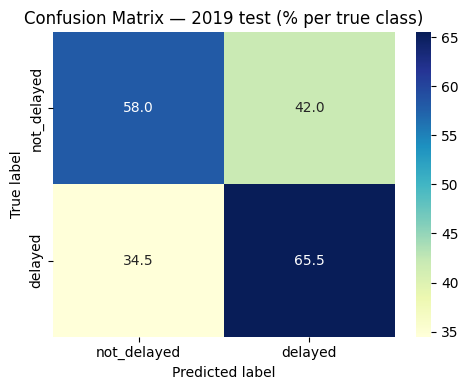

In [0]:
lr_test_metrics = train_eval_lr_full_train_vs_2019(
    train_df_all=train_df_all,
    test_2019_df=test_2019_df,
    label_col=label_col,
    numeric_cols=numeric_cols,
    vector_cols=[],              
    categorical_cols=categorical_cols,
    alpha=lr_best["alpha"],
    regParam=lr_best["regParam"],
    elasticNetParam=lr_best["elasticNetParam"],
)

## Building MLP model - Grid search with CV + thresholds + layers

In [0]:
# Drop some unwanted columns
drop_cols = ['DISTANCE', 'LONGITUDE', 'LATITUDE', 'ELEVATION']
df_5y = df_5y.drop(*drop_cols)


In [0]:
label_col = "DEP_DELAY_GROUP_CLASSIFIED"
year_col  = "YEAR"
leakage_cols = {"DEP_DELAY_GROUP"}   

# Train = 2015–2018, Blind test = 2019
train_df_all = df_5y.filter((col(year_col) >= 2015) & (col(year_col) <= 2018))
test_2019_df = df_5y.filter(col(year_col) == 2019)

numeric_cols = [
    c for c, t in df_5y.dtypes
    if t in ("int", "bigint", "double", "float")
    and c != label_col
    and c not in leakage_cols
]

low_card_cols = ["QUARTER", "DISTANCE_GROUP", "season", "HourlySkyConditions"]
high_card_idx_only = ["ORIGIN_AIRPORT_ID", "DEST_AIRPORT_ID"]

categorical_cols = low_card_cols + high_card_idx_only

print("Numeric features:", numeric_cols)
print("Low-card categoricals (OHE):", low_card_cols)
print("High-card index-only categoricals:", high_card_idx_only)

Numeric features: ['HourlyPrecipitation', 'HourlySeaLevelPressure', 'HourlyWetBulbTemperature', 'HourlyStationPressure', 'HourlyWindSpeed', 'HourlyRelativeHumidity', 'HourlyDewPointTemperature', 'HourlyDryBulbTemperature', 'HourlyVisibility', 'day_of_week', 'month', 'HourlyAltimeterSetting', 'is_us_holiday', 'is_holiday_window', 'is_summer_peak', 'is_weekday', 'is_superbowl_window', 'hour_of_day', 'is_weekend', 'is_CES_window', 'is_CES_LasVegas_Peak', 'is_GHC_window', 'is_GHC_Host_Airport_Peak', 'route_avg_delay_last_7days', 'origin_avg_delay_last_7days', 'dest_avg_delay_last_7days', 'Weather_Index', 'CRS_DEP_TIME_SIN', 'CRS_DEP_TIME_COS', 'is_disaster_day', 'days_since_disaster', 'disaster_severity', 'is_disruption_day', 'is_airport_disrupted', 'is_federal_shutdown_day', 'disruption_severity', 'days_into_disruption', 'YEAR']
Low-card categoricals (OHE): ['QUARTER', 'DISTANCE_GROUP', 'season', 'HourlySkyConditions']
High-card index-only categoricals: ['ORIGIN_AIRPORT_ID', 'DEST_AIRPORT

In [0]:
def build_mlp_feature_pipeline(
    label_col,
    numeric_cols,
    low_card_cols,
    high_card_idx_only
):
    """
    Improved Feature pipeline for MLP:
      - StringIndex label -> 'label'
      - StringIndex + OneHotEncode 'low_card_cols'
      - FeatureHash 'high_card_idx_only' (Avoids OOM, fixes ordinality issue)
      - Impute + Assemble + Scale numeric -> 'num_scaled'
      - Final Assemble -> 'features'
    """
    stages = []

    # 1. Label Indexer
    label_indexer = StringIndexer(
        inputCol=label_col, 
        outputCol="label", 
        handleInvalid="skip"
    )
    stages.append(label_indexer)

    # 2. Low Cardinality: StringIndexer -> OHE
    low_card_ohe_cols = []
    for c in low_card_cols:
        idx_col = f"{c}__idx"
        oh_col = f"{c}__oh"
        
        si = StringIndexer(inputCol=c, outputCol=idx_col, handleInvalid="keep")
        ohe = OneHotEncoder(inputCol=idx_col, outputCol=oh_col, handleInvalid="keep")
        
        stages.extend([si, ohe])
        low_card_ohe_cols.append(oh_col)

    # 3. High Cardinality: FeatureHasher
    hasher = FeatureHasher(
        inputCols=high_card_idx_only, 
        outputCol="high_card_hashed",
        numFeatures=256 
    )
    stages.append(hasher)

    # 4. Numerics: Impute -> Assemble -> Scale
    imputer = Imputer(
        inputCols=numeric_cols,
        outputCols=[f"{c}__imp" for c in numeric_cols],
        strategy="median"
    )
    stages.append(imputer)
    
    num_assembler = VectorAssembler(
        inputCols=[f"{c}__imp" for c in numeric_cols],
        outputCol="num_vec",
        handleInvalid="keep"
    )
    stages.append(num_assembler)

    scaler = StandardScaler(
        inputCol="num_vec",
        outputCol="num_scaled",
        withMean=True,
        withStd=True
    )
    stages.append(scaler)

    # 5. Final Assembly
    final_inputs = ["num_scaled"] + low_card_ohe_cols + ["high_card_hashed"]
    
    final_assembler = VectorAssembler(
        inputCols=final_inputs,
        outputCol="features",
        handleInvalid="skip"
    )
    stages.append(final_assembler)

    return Pipeline(stages=stages)

In [0]:
def downsample_majority(
    df,
    label_col="DEP_DELAY_GROUP_CLASSIFIED",
    year_col="YEAR",
    month_col="MONTH", 
    minority_label="delayed",
    majority_label="not_delayed",
    maj_to_min_ratio=2.0,
    seed=42,
):
    
    # 1. Create the Composite Key ('ym_key') on the input DataFrame
    df_keyed = df.withColumn(
        "ym_key",
        F.concat_ws(
            "-",
            F.col(year_col).cast("string"),
            F.col(month_col).cast("string")
        )
    )
    # Split into minority and majority
    df_min = df_keyed.filter(F.col(label_col) == minority_label)
    df_maj = df_keyed.filter(F.col(label_col) == majority_label)
    # 2. Count per ym_key
    min_counts = df_min.groupBy("ym_key").count().withColumnRenamed("count", "n_min")
    maj_counts = df_maj.groupBy("ym_key").count().withColumnRenamed("count", "n_maj")
    # 3. Join counts on the composite key
    counts = maj_counts.join(min_counts, on="ym_key", how="left").fillna({"n_min": 0})
    # 4. Build fractions dict
    frac_dict: Dict[str, float] = {}
    for row in counts.collect():
        key   = row["ym_key"]
        n_maj = row["n_maj"]
        n_min = row["n_min"]
        
        if n_maj == 0:
            continue
            
        # Logic to calculate the sampling fraction
        if n_min > 0:
            target_maj = min(n_maj, int(maj_to_min_ratio * n_min))
            frac = float(target_maj) / float(n_maj)
        else:
            frac = 1.0 
        frac_dict[key] = frac
    # 5. Undersample majority by ym_key
    df_maj_sampled = df_maj.sampleBy(
        col="ym_key",
        fractions=frac_dict,
        seed=seed
    ).drop("ym_key")
    # 6. Union minority + sampled majority
    df_min_final = df_min.drop("ym_key")
    
    balanced = df_min_final.unionByName(df_maj_sampled)

    return balanced

In [0]:
# Sanity checks
balanced_train = downsample_majority(train_df_all)
balanced_2017 = balanced_train.filter(col("YEAR") == 2017)
balanced_2017.groupBy("YEAR", "month", label_col).count().orderBy("month", label_col).show(50, truncate=False)

+----+-----+--------------------------+------+
|YEAR|month|DEP_DELAY_GROUP_CLASSIFIED|count |
+----+-----+--------------------------+------+
|2017|1    |delayed                   |75752 |
|2017|1    |not_delayed               |151330|
|2017|2    |delayed                   |51442 |
|2017|2    |not_delayed               |102568|
|2017|3    |delayed                   |72020 |
|2017|3    |not_delayed               |143932|
|2017|4    |delayed                   |74909 |
|2017|4    |not_delayed               |149627|
|2017|5    |delayed                   |80124 |
|2017|5    |not_delayed               |159898|
|2017|6    |delayed                   |93724 |
|2017|6    |not_delayed               |187838|
|2017|7    |delayed                   |94960 |
|2017|7    |not_delayed               |189696|
|2017|8    |delayed                   |88846 |
|2017|8    |not_delayed               |177670|
|2017|9    |delayed                   |51306 |
|2017|9    |not_delayed               |102626|
|2017|10   |d

In [0]:
def prf_for_delayed(pred_df, label_names, threshold=None):
    """
    Compute precision/recall/F1 for the 'delayed' class.

    Parameters
    ----------
    pred_df : DataFrame
        Must contain:
          - 'label' (indexed)
          - 'prediction' (indexed)
          - 'probability' (VectorUDT) if threshold is not None
    label_names : list[str]
        Output of StringIndexerModel.labels (e.g. ['not_delayed', 'delayed']).
    threshold : float or None, optional
        If None (default), use the existing 'prediction' column.
        If set (e.g. 0.3, 0.4, 0.5), recompute predictions by
        thresholding P(delayed) and compute metrics on that.

    Returns
    -------
    (precision, recall, f1) for the 'delayed' class.
    """

    if "delayed" not in label_names:
        raise ValueError(f"'delayed' not found in label names: {label_names}")

    delayed_pos = label_names.index("delayed")
    delayed_idx = float(delayed_pos)

    if threshold is None:
        rdd = (
            pred_df
            .select("prediction", "label")
            .rdd.map(lambda r: (float(r[0]), float(r[1])))
        )
        mc = MulticlassMetrics(rdd)
        p = mc.precision(delayed_idx)
        r = mc.recall(delayed_idx)
        f1 = 2 * p * r / (p + r) if (p + r) > 0 else 0.0
        return p, r, f1

    other_positions = [i for i, name in enumerate(label_names) if name != "delayed"]
    if not other_positions:
        raise ValueError("No 'other' class found besides 'delayed'.")
    other_pos = other_positions[0]  # for binary: this is the other class

    # 1. Convert probability vector → array, extract P(delayed)
    df2 = pred_df.withColumn(
        "prob_delayed",
        vector_to_array("probability")[delayed_pos]
    )

    # 2. Apply custom decision rule to get a new prediction column
    df_thr = df2.withColumn(
        "pred_thr",
        F.when(
            F.col("prob_delayed") >= F.lit(float(threshold)),
            F.lit(float(delayed_pos))
        ).otherwise(F.lit(float(other_pos)))
    )

    # 3. Compute metrics on (pred_thr, label)
    rdd = (
        df_thr
        .select("pred_thr", "label")
        .rdd.map(lambda r: (float(r[0]), float(r[1])))
    )
    mc = MulticlassMetrics(rdd)
    p = mc.precision(delayed_idx)
    r = mc.recall(delayed_idx)
    f1 = 2 * p * r / (p + r) if (p + r) > 0 else 0.0
    return p, r, f1

In [0]:
def train_eval_mlp_split(
    train_df,
    valid_df,
    label_col,
    numeric_cols,
    categorical_cols,
    hidden_layers,          
    maxIter=50,
    blockSize=128,
    balance_train=True,
    maj_to_min_ratio=1.2,
    threshold=None,
    seed=42
):
    """
    Train + evaluate an MLP on a single time-based split.

    Returns:
      - metrics: dict with train/valid P/R/F1 + timings
    """

    if balance_train:
        train_raw = downsample_majority(
            train_df,
            label_col=label_col,
            minority_label="delayed",
            majority_label="not_delayed",
            maj_to_min_ratio=maj_to_min_ratio,
            seed=seed
        )
    else:
        train_raw = train_df

    feat_pipe = build_mlp_feature_pipeline(
        label_col=label_col,
        numeric_cols=numeric_cols,
        low_card_cols=low_card_cols,
        high_card_idx_only=high_card_idx_only,
    )

    t_feat0 = time.time()
    feat_model = feat_pipe.fit(train_raw)
    feat_fit_time = time.time() - t_feat0

    # Transform train + valid into features
    train_feat = feat_model.transform(train_raw).select("features", "label")
    valid_feat = feat_model.transform(valid_df).select("features", "label")

    # Cache train features for iterative MLP
    train_feat = train_feat.cache()
    _ = train_feat.count() 

    # Get label names from label indexer (stage 0)
    label_names = feat_model.stages[0].labels 

    # Detect input dimension
    sample = train_feat.select("features").limit(1).collect()[0]["features"]
    input_dim = sample.size
    layers = [input_dim] + hidden_layers + [2]

    trainer = MultilayerPerceptronClassifier(
        featuresCol="features",
        labelCol="label",
        predictionCol="prediction",
        probabilityCol="probability",
        maxIter=maxIter,
        blockSize=blockSize,
        layers=layers,
        seed=seed
    )

    print(f"Training MLP: layers={layers}, maxIter={maxIter}, blockSize={blockSize}")

    t0 = time.time()
    mlp_model = trainer.fit(train_feat)
    train_time = time.time() - t0

    t1 = time.time()
    pred_train = mlp_model.transform(train_feat)
    pred_valid = mlp_model.transform(valid_feat)
    eval_time = time.time() - t1

    train_p, train_r, train_f1 = prf_for_delayed(pred_train, label_names)
    valid_p, valid_r, valid_f1 = prf_for_delayed(pred_valid, label_names)

    print("\n=== Metrics for 'delayed' ===")
    print(f"TRAIN: P={train_p:.4f}, R={train_r:.4f}, F1={train_f1:.4f}")
    print(f"VALID: P={valid_p:.4f}, R={valid_r:.4f}, F1={valid_f1:.4f}")
    print(f"Times: feature_fit={feat_fit_time:.1f}s, train={train_time:.1f}s, eval={eval_time:.1f}s")

    metrics = {
        "layers": layers,
        "hidden_layers": hidden_layers,
        "maxIter": maxIter,
        "blockSize": blockSize,
        "threshold": threshold,
        "train_precision_delayed": train_p,
        "train_recall_delayed":    train_r,
        "train_f1_delayed":        train_f1,
        "valid_precision_delayed": valid_p,
        "valid_recall_delayed":    valid_r,
        "valid_f1_delayed":        valid_f1,
        "feature_fit_time_sec":    feat_fit_time,
        "train_time_sec":          train_time,
        "eval_time_sec":           eval_time,
    }
    
    return metrics

In [0]:
def year_time_cv_mlp(
    df,
    year_col,
    label_col,
    numeric_cols,
    categorical_cols,
    hidden_layers,         
    maxIter=50,
    blockSize=128,
    balance_train=True,
    maj_to_min_ratio=1.2,
    threshold=None, 
    seed=42
):
    """
    Time-aware cross-fold validation (MLP) on 2015–2018:
      Fold 1: train 2015       -> valid 2016
      Fold 2: train 2015–2016  -> valid 2017
      Fold 3: train 2015–2017  -> valid 2018
    """

    train_df_all = df.filter((col(year_col) >= 2015) & (col(year_col) <= 2018))

    folds = [
        (
            train_df_all.filter(col(year_col) == 2015),
            train_df_all.filter(col(year_col) == 2016),
            [2015],
            2016
        ),
        (
            train_df_all.filter(col(year_col).isin(2015, 2016)),
            train_df_all.filter(col(year_col) == 2017),
            [2015, 2016],
            2017
        ),
        (
            train_df_all.filter(col(year_col).isin(2015, 2016, 2017)),
            train_df_all.filter(col(year_col) == 2018),
            [2015, 2016, 2017],
            2018
        ),
    ]

    cv_results = []

    for i, (tr, va, tr_years, va_year) in enumerate(folds, start=1):
        print(f"\n=== Fold {i}: train_years={tr_years}, valid_year={va_year} ===")

        metrics = train_eval_mlp_split(
            train_df=tr,
            valid_df=va,
            label_col=label_col,
            numeric_cols=numeric_cols,
            categorical_cols=categorical_cols,
            hidden_layers=hidden_layers,
            maxIter=maxIter,
            blockSize=blockSize,
            balance_train=balance_train,
            maj_to_min_ratio=maj_to_min_ratio,
            threshold=threshold,
            seed=seed + i   
        )

        cv_results.append({
            "fold": i,
            "train_years": tr_years,
            "valid_year": va_year,
            "threshold": threshold,
            **metrics
        })

    import pandas as pd
    cv_df = pd.DataFrame(cv_results)
    display(cv_df)

    # Average validation metrics
    avg_val_p  = cv_df["valid_precision_delayed"].mean()
    avg_val_r  = cv_df["valid_recall_delayed"].mean()
    avg_val_f1 = cv_df["valid_f1_delayed"].mean()

    print("\n=== Average validation metrics over folds (2016–2018) ===")
    print(f"Precision(delayed): {avg_val_p:.4f}")
    print(f"Recall   (delayed): {avg_val_r:.4f}")
    print(f"F1       (delayed): {avg_val_f1:.4f}")

    return cv_df

In [0]:
hidden_layer_configs = [
    [32],
    [64, 32]      
]
threshold_list = [0.3, 0.5]
ratio_list     = [1.0, 1.2]   

all_cv = []

for hidden_layers in hidden_layer_configs:
    for r in ratio_list:
        for thr in threshold_list:
            print(f"\n=== Running CV for hidden_layers={hidden_layers}, "
                  f"maj_to_min_ratio={r}, threshold={thr} ===")

            cv_df_thr = year_time_cv_mlp(
                df=df_5y,
                year_col="YEAR",
                label_col=label_col,
                numeric_cols=numeric_cols,
                categorical_cols=categorical_cols,
                hidden_layers=hidden_layers,
                maxIter=50,
                blockSize=128,
                balance_train=True,
                maj_to_min_ratio=r,   
                threshold=thr,
                seed=42
            )

            # add config info to the CV results
            cv_df_thr = cv_df_thr.copy()
            cv_df_thr["hidden_layers_cfg"] = str(hidden_layers)
            cv_df_thr["threshold"]         = thr
            cv_df_thr["maj_to_min_ratio"]  = r

            all_cv.append(cv_df_thr)

full_cv1 = pd.concat(all_cv, ignore_index=True)

# sort by validation F1
display(
    full_cv1.sort_values(
        by=["valid_f1_delayed", "valid_recall_delayed"],
        ascending=False
    )
)


=== Running CV for hidden_layers=[32], maj_to_min_ratio=1.0, threshold=0.3 ===

=== Fold 1: train_years=[2015], valid_year=2016 ===
Training MLP: layers=[323, 32, 2], maxIter=50, blockSize=128


/databricks/spark/python/pyspark/sql/context.py:165: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(



=== Metrics for 'delayed' ===
TRAIN: P=0.6173, R=0.6580, F1=0.6370
VALID: P=0.2471, R=0.6284, F1=0.3547
Times: feature_fit=14.1s, train=30.2s, eval=0.1s

=== Fold 2: train_years=[2015, 2016], valid_year=2017 ===
Training MLP: layers=[323, 32, 2], maxIter=50, blockSize=128

=== Metrics for 'delayed' ===
TRAIN: P=0.6149, R=0.6626, F1=0.6378
VALID: P=0.2562, R=0.6772, F1=0.3717
Times: feature_fit=15.3s, train=48.0s, eval=0.1s

=== Fold 3: train_years=[2015, 2016, 2017], valid_year=2018 ===
Training MLP: layers=[323, 32, 2], maxIter=50, blockSize=128

=== Metrics for 'delayed' ===
TRAIN: P=0.6168, R=0.6655, F1=0.6402
VALID: P=0.2572, R=0.6583, F1=0.3699
Times: feature_fit=18.2s, train=129.5s, eval=0.1s


fold,train_years,valid_year,threshold,layers,hidden_layers,maxIter,blockSize,train_precision_delayed,train_recall_delayed,train_f1_delayed,valid_precision_delayed,valid_recall_delayed,valid_f1_delayed,feature_fit_time_sec,train_time_sec,eval_time_sec
1,List(2015),2016,0.3,"List(323, 32, 2)",List(32),50,128,0.6173489761406799,0.657993796590146,0.6370237167879895,0.2471160904335161,0.6284317926591406,0.35473926830251573,14.113160133361816,30.169361352920532,0.1370692253112793
2,"List(2015, 2016)",2017,0.3,"List(323, 32, 2)",List(32),50,128,0.6148608508639117,0.6626040326796234,0.6378402797095255,0.25615950912114926,0.6771647382508327,0.37170830487456613,15.319155216217041,48.00491952896118,0.12939691543579102
3,"List(2015, 2016, 2017)",2018,0.3,"List(323, 32, 2)",List(32),50,128,0.6167608695494704,0.6654855629710509,0.6401974598343447,0.25718170596996537,0.6582779490461484,0.3698623855468943,18.21656608581543,129.49355363845825,0.13637661933898926



=== Average validation metrics over folds (2016–2018) ===
Precision(delayed): 0.2535
Recall   (delayed): 0.6546
F1       (delayed): 0.3654

=== Running CV for hidden_layers=[32], maj_to_min_ratio=1.0, threshold=0.5 ===

=== Fold 1: train_years=[2015], valid_year=2016 ===
Training MLP: layers=[323, 32, 2], maxIter=50, blockSize=128


/databricks/spark/python/pyspark/sql/context.py:165: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(



=== Metrics for 'delayed' ===
TRAIN: P=0.6164, R=0.6587, F1=0.6369
VALID: P=0.2470, R=0.6350, F1=0.3557
Times: feature_fit=14.5s, train=23.6s, eval=0.1s

=== Fold 2: train_years=[2015, 2016], valid_year=2017 ===
Training MLP: layers=[323, 32, 2], maxIter=50, blockSize=128

=== Metrics for 'delayed' ===
TRAIN: P=0.6161, R=0.6608, F1=0.6377
VALID: P=0.2586, R=0.6641, F1=0.3722
Times: feature_fit=12.9s, train=63.6s, eval=0.1s

=== Fold 3: train_years=[2015, 2016, 2017], valid_year=2018 ===
Training MLP: layers=[323, 32, 2], maxIter=50, blockSize=128

=== Metrics for 'delayed' ===
TRAIN: P=0.6164, R=0.6638, F1=0.6392
VALID: P=0.2577, R=0.6557, F1=0.3699
Times: feature_fit=15.9s, train=262.8s, eval=0.1s


fold,train_years,valid_year,threshold,layers,hidden_layers,maxIter,blockSize,train_precision_delayed,train_recall_delayed,train_f1_delayed,valid_precision_delayed,valid_recall_delayed,valid_f1_delayed,feature_fit_time_sec,train_time_sec,eval_time_sec
1,List(2015),2016,0.5,"List(323, 32, 2)",List(32),50,128,0.616448088178265,0.6587102657224547,0.636878835833779,0.24704259288976818,0.6350294048111591,0.3557063621443428,14.491658449172974,23.568646669387817,0.14702463150024414
2,"List(2015, 2016)",2017,0.5,"List(323, 32, 2)",List(32),50,128,0.6160578226170758,0.660811469584574,0.6376503493332842,0.25859927759747275,0.664092461194232,0.37224529819167385,12.871562480926514,63.56524729728699,0.13519835472106934
3,"List(2015, 2016, 2017)",2018,0.5,"List(323, 32, 2)",List(32),50,128,0.6163906714574949,0.6637566991519032,0.6391974031550589,0.25765900075048986,0.6556829488939896,0.3699438386398899,15.903442859649658,262.7995398044586,0.14227533340454102



=== Average validation metrics over folds (2016–2018) ===
Precision(delayed): 0.2544
Recall   (delayed): 0.6516
F1       (delayed): 0.3660

=== Running CV for hidden_layers=[32], maj_to_min_ratio=1.2, threshold=0.3 ===

=== Fold 1: train_years=[2015], valid_year=2016 ===
Training MLP: layers=[323, 32, 2], maxIter=50, blockSize=128


/databricks/spark/python/pyspark/sql/context.py:165: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(



=== Metrics for 'delayed' ===
TRAIN: P=0.5992, R=0.5554, F1=0.5765
VALID: P=0.2648, R=0.5320, F1=0.3536
Times: feature_fit=10.5s, train=26.7s, eval=0.1s

=== Fold 2: train_years=[2015, 2016], valid_year=2017 ===
Training MLP: layers=[323, 32, 2], maxIter=50, blockSize=128

=== Metrics for 'delayed' ===
TRAIN: P=0.5950, R=0.5510, F1=0.5722
VALID: P=0.2771, R=0.5598, F1=0.3707
Times: feature_fit=12.4s, train=39.6s, eval=0.4s

=== Fold 3: train_years=[2015, 2016, 2017], valid_year=2018 ===
Training MLP: layers=[323, 32, 2], maxIter=50, blockSize=128

=== Metrics for 'delayed' ===
TRAIN: P=0.5951, R=0.5642, F1=0.5792
VALID: P=0.2729, R=0.5548, F1=0.3659
Times: feature_fit=15.3s, train=54.6s, eval=0.1s


fold,train_years,valid_year,threshold,layers,hidden_layers,maxIter,blockSize,train_precision_delayed,train_recall_delayed,train_f1_delayed,valid_precision_delayed,valid_recall_delayed,valid_f1_delayed,feature_fit_time_sec,train_time_sec,eval_time_sec
1,List(2015),2016,0.3,"List(323, 32, 2)",List(32),50,128,0.5991544672113771,0.555444379310887,0.5764720485456526,0.26480320920839323,0.5319968181728628,0.35360055195736567,10.51416015625,26.70759415626526,0.13826298713684082
2,"List(2015, 2016)",2017,0.3,"List(323, 32, 2)",List(32),50,128,0.595028318101387,0.5510422356527408,0.5721911859775807,0.27713600098969093,0.5598388912504263,0.37074352637841057,12.38239860534668,39.5549430847168,0.37502312660217285
3,"List(2015, 2016, 2017)",2018,0.3,"List(323, 32, 2)",List(32),50,128,0.5950943561105382,0.5641911035419043,0.5792308334242742,0.2729453554019693,0.5548385133434096,0.36589404778990536,15.322141885757446,54.572378158569336,0.14443373680114746



=== Average validation metrics over folds (2016–2018) ===
Precision(delayed): 0.2716
Recall   (delayed): 0.5489
F1       (delayed): 0.3634

=== Running CV for hidden_layers=[32], maj_to_min_ratio=1.2, threshold=0.5 ===

=== Fold 1: train_years=[2015], valid_year=2016 ===
Training MLP: layers=[323, 32, 2], maxIter=50, blockSize=128


/databricks/spark/python/pyspark/sql/context.py:165: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(



=== Metrics for 'delayed' ===
TRAIN: P=0.5992, R=0.5554, F1=0.5765
VALID: P=0.2648, R=0.5320, F1=0.3536
Times: feature_fit=10.7s, train=26.3s, eval=0.1s

=== Fold 2: train_years=[2015, 2016], valid_year=2017 ===
Training MLP: layers=[323, 32, 2], maxIter=50, blockSize=128

=== Metrics for 'delayed' ===
TRAIN: P=0.5950, R=0.5510, F1=0.5722
VALID: P=0.2771, R=0.5598, F1=0.3707
Times: feature_fit=12.0s, train=38.7s, eval=0.1s

=== Fold 3: train_years=[2015, 2016, 2017], valid_year=2018 ===
Training MLP: layers=[323, 32, 2], maxIter=50, blockSize=128

=== Metrics for 'delayed' ===
TRAIN: P=0.5942, R=0.5641, F1=0.5788
VALID: P=0.2745, R=0.5457, F1=0.3652
Times: feature_fit=36.1s, train=62.0s, eval=0.1s


fold,train_years,valid_year,threshold,layers,hidden_layers,maxIter,blockSize,train_precision_delayed,train_recall_delayed,train_f1_delayed,valid_precision_delayed,valid_recall_delayed,valid_f1_delayed,feature_fit_time_sec,train_time_sec,eval_time_sec
1,List(2015),2016,0.5,"List(323, 32, 2)",List(32),50,128,0.5991544672113771,0.555444379310887,0.5764720485456526,0.26480320920839323,0.5319968181728628,0.35360055195736567,10.65156078338623,26.315110206604004,0.14063358306884766
2,"List(2015, 2016)",2017,0.5,"List(323, 32, 2)",List(32),50,128,0.595028318101387,0.5510422356527408,0.5721911859775807,0.27713600098969093,0.5598388912504263,0.37074352637841057,12.014155864715576,38.685314893722534,0.141587495803833
3,"List(2015, 2016, 2017)",2018,0.5,"List(323, 32, 2)",List(32),50,128,0.5941918326067601,0.5641293584055062,0.578770482486483,0.27446080973395093,0.545664717496332,0.36522111612126124,36.1395788192749,62.02395796775818,0.13902592658996582



=== Average validation metrics over folds (2016–2018) ===
Precision(delayed): 0.2721
Recall   (delayed): 0.5458
F1       (delayed): 0.3632

=== Running CV for hidden_layers=[64, 32], maj_to_min_ratio=1.0, threshold=0.3 ===

=== Fold 1: train_years=[2015], valid_year=2016 ===
Training MLP: layers=[323, 64, 32, 2], maxIter=50, blockSize=128


/databricks/spark/python/pyspark/sql/context.py:165: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(



=== Metrics for 'delayed' ===
TRAIN: P=0.6095, R=0.6732, F1=0.6398
VALID: P=0.2399, R=0.6545, F1=0.3511
Times: feature_fit=33.2s, train=47.6s, eval=0.1s

=== Fold 2: train_years=[2015, 2016], valid_year=2017 ===
Training MLP: layers=[323, 64, 32, 2], maxIter=50, blockSize=128

=== Metrics for 'delayed' ===
TRAIN: P=0.6137, R=0.6706, F1=0.6409
VALID: P=0.2545, R=0.6828, F1=0.3708
Times: feature_fit=12.9s, train=87.9s, eval=0.1s

=== Fold 3: train_years=[2015, 2016, 2017], valid_year=2018 ===
Training MLP: layers=[323, 64, 32, 2], maxIter=50, blockSize=128

=== Metrics for 'delayed' ===
TRAIN: P=0.6131, R=0.6631, F1=0.6371
VALID: P=0.2574, R=0.6424, F1=0.3676
Times: feature_fit=16.7s, train=149.6s, eval=0.1s


fold,train_years,valid_year,threshold,layers,hidden_layers,maxIter,blockSize,train_precision_delayed,train_recall_delayed,train_f1_delayed,valid_precision_delayed,valid_recall_delayed,valid_f1_delayed,feature_fit_time_sec,train_time_sec,eval_time_sec
1,List(2015),2016,0.3,"List(323, 64, 32, 2)","List(64, 32)",50,128,0.6094701987428238,0.6732283110868544,0.6397646670874884,0.23986671113239127,0.6545033197391493,0.3510707052159954,33.20619058609009,47.63455247879028,0.13626384735107422
2,"List(2015, 2016)",2017,0.3,"List(323, 64, 32, 2)","List(64, 32)",50,128,0.6137192595084962,0.6706376755413811,0.6409172503370675,0.2544578338419815,0.6828367098127327,0.3707546389190159,12.876329183578491,87.86998295783997,0.14646291732788086
3,"List(2015, 2016, 2017)",2018,0.3,"List(323, 64, 32, 2)","List(64, 32)",50,128,0.6130688906769548,0.6631001685876698,0.6371038097381858,0.2574460536673159,0.6424156186917473,0.36758397635241113,16.747873783111572,149.63073301315308,0.13663625717163086



=== Average validation metrics over folds (2016–2018) ===
Precision(delayed): 0.2506
Recall   (delayed): 0.6599
F1       (delayed): 0.3631

=== Running CV for hidden_layers=[64, 32], maj_to_min_ratio=1.0, threshold=0.5 ===

=== Fold 1: train_years=[2015], valid_year=2016 ===
Training MLP: layers=[323, 64, 32, 2], maxIter=50, blockSize=128


/databricks/spark/python/pyspark/sql/context.py:165: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(



=== Metrics for 'delayed' ===
TRAIN: P=0.6127, R=0.6591, F1=0.6350
VALID: P=0.2429, R=0.6417, F1=0.3524
Times: feature_fit=9.7s, train=41.8s, eval=0.1s

=== Fold 2: train_years=[2015, 2016], valid_year=2017 ===
Training MLP: layers=[323, 64, 32, 2], maxIter=50, blockSize=128

=== Metrics for 'delayed' ===
TRAIN: P=0.6095, R=0.6836, F1=0.6445
VALID: P=0.2506, R=0.6997, F1=0.3690
Times: feature_fit=11.7s, train=124.6s, eval=0.1s

=== Fold 3: train_years=[2015, 2016, 2017], valid_year=2018 ===
Training MLP: layers=[323, 64, 32, 2], maxIter=50, blockSize=128

=== Metrics for 'delayed' ===
TRAIN: P=0.6151, R=0.6583, F1=0.6360
VALID: P=0.2561, R=0.6531, F1=0.3679
Times: feature_fit=31.2s, train=136.4s, eval=0.1s


fold,train_years,valid_year,threshold,layers,hidden_layers,maxIter,blockSize,train_precision_delayed,train_recall_delayed,train_f1_delayed,valid_precision_delayed,valid_recall_delayed,valid_f1_delayed,feature_fit_time_sec,train_time_sec,eval_time_sec
1,List(2015),2016,0.5,"List(323, 64, 32, 2)","List(64, 32)",50,128,0.612676732669133,0.6590954521054984,0.635038968374105,0.24289800466917946,0.6417242941860236,0.35240701213894315,9.65873670578003,41.83613586425781,0.12488245964050293
2,"List(2015, 2016)",2017,0.5,"List(323, 64, 32, 2)","List(64, 32)",50,128,0.6095488774174763,0.6836184871284338,0.6444624150521958,0.250562597992003,0.6996599386207896,0.368984327727405,11.741872310638428,124.5977623462677,0.11583375930786133
3,"List(2015, 2016, 2017)",2018,0.5,"List(323, 64, 32, 2)","List(64, 32)",50,128,0.6151470234332577,0.6582899098286533,0.6359876457328375,0.25608550936614666,0.6530990148405605,0.36791034037431253,31.21458387374878,136.38584923744202,0.1228325366973877



=== Average validation metrics over folds (2016–2018) ===
Precision(delayed): 0.2498
Recall   (delayed): 0.6648
F1       (delayed): 0.3631

=== Running CV for hidden_layers=[64, 32], maj_to_min_ratio=1.2, threshold=0.3 ===

=== Fold 1: train_years=[2015], valid_year=2016 ===
Training MLP: layers=[323, 64, 32, 2], maxIter=50, blockSize=128


/databricks/spark/python/pyspark/sql/context.py:165: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(



=== Metrics for 'delayed' ===
TRAIN: P=0.5945, R=0.5447, F1=0.5685
VALID: P=0.2629, R=0.5268, F1=0.3508
Times: feature_fit=11.7s, train=41.2s, eval=0.1s

=== Fold 2: train_years=[2015, 2016], valid_year=2017 ===
Training MLP: layers=[323, 64, 32, 2], maxIter=50, blockSize=128

=== Metrics for 'delayed' ===
TRAIN: P=0.5935, R=0.5586, F1=0.5756
VALID: P=0.2736, R=0.5823, F1=0.3723
Times: feature_fit=26.3s, train=83.1s, eval=0.1s

=== Fold 3: train_years=[2015, 2016, 2017], valid_year=2018 ===
Training MLP: layers=[323, 64, 32, 2], maxIter=50, blockSize=128

=== Metrics for 'delayed' ===
TRAIN: P=0.5885, R=0.5581, F1=0.5729
VALID: P=0.2707, R=0.5416, F1=0.3610
Times: feature_fit=18.1s, train=154.4s, eval=0.1s


fold,train_years,valid_year,threshold,layers,hidden_layers,maxIter,blockSize,train_precision_delayed,train_recall_delayed,train_f1_delayed,valid_precision_delayed,valid_recall_delayed,valid_f1_delayed,feature_fit_time_sec,train_time_sec,eval_time_sec
1,List(2015),2016,0.3,"List(323, 64, 32, 2)","List(64, 32)",50,128,0.5945134956240347,0.5446692675169965,0.568500930083725,0.26289770021354064,0.5267992592154777,0.35075306310431464,11.736960887908936,41.155691623687744,0.12995338439941406
2,"List(2015, 2016)",2017,0.3,"List(323, 64, 32, 2)","List(64, 32)",50,128,0.5935284503937932,0.5586336111453727,0.5755526112673185,0.2736172403083079,0.5822873798924696,0.37229350605715567,26.331015825271606,83.1355242729187,0.14493966102600098
3,"List(2015, 2016, 2017)",2018,0.3,"List(323, 64, 32, 2)","List(64, 32)",50,128,0.5884670761628238,0.5580689560304286,0.5728650432804052,0.27066614438120695,0.5416228249352403,0.36095273300939695,18.08375358581543,154.44207429885864,0.13009262084960938



=== Average validation metrics over folds (2016–2018) ===
Precision(delayed): 0.2691
Recall   (delayed): 0.5502
F1       (delayed): 0.3613

=== Running CV for hidden_layers=[64, 32], maj_to_min_ratio=1.2, threshold=0.5 ===

=== Fold 1: train_years=[2015], valid_year=2016 ===
Training MLP: layers=[323, 64, 32, 2], maxIter=50, blockSize=128


/databricks/spark/python/pyspark/sql/context.py:165: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(



=== Metrics for 'delayed' ===
TRAIN: P=0.5964, R=0.5467, F1=0.5705
VALID: P=0.2638, R=0.5226, F1=0.3506
Times: feature_fit=11.1s, train=43.3s, eval=0.1s

=== Fold 2: train_years=[2015, 2016], valid_year=2017 ===
Training MLP: layers=[323, 64, 32, 2], maxIter=50, blockSize=128


/databricks/spark/python/pyspark/sql/context.py:165: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(



=== Metrics for 'delayed' ===
TRAIN: P=0.6012, R=0.5289, F1=0.5628
VALID: P=0.2810, R=0.5453, F1=0.3709
Times: feature_fit=14.2s, train=92.1s, eval=0.1s

=== Fold 3: train_years=[2015, 2016, 2017], valid_year=2018 ===
Training MLP: layers=[323, 64, 32, 2], maxIter=50, blockSize=128

=== Metrics for 'delayed' ===
TRAIN: P=0.5918, R=0.5584, F1=0.5746
VALID: P=0.2701, R=0.5681, F1=0.3661
Times: feature_fit=15.4s, train=160.5s, eval=0.1s


fold,train_years,valid_year,threshold,layers,hidden_layers,maxIter,blockSize,train_precision_delayed,train_recall_delayed,train_f1_delayed,valid_precision_delayed,valid_recall_delayed,valid_f1_delayed,feature_fit_time_sec,train_time_sec,eval_time_sec
1,List(2015),2016,0.5,"List(323, 64, 32, 2)","List(64, 32)",50,128,0.5964137647139539,0.5466861618142166,0.5704683279526105,0.2638022165599869,0.5225646216285439,0.3506091528452538,11.093656301498413,43.31285381317139,0.14108800888061523
2,"List(2015, 2016)",2017,0.5,"List(323, 64, 32, 2)","List(64, 32)",50,128,0.6011792868472067,0.5289476620912844,0.5627551463562929,0.2810272440797028,0.5452975303509452,0.3709037097758121,14.150512218475342,92.09669804573059,0.13607335090637207
3,"List(2015, 2016, 2017)",2018,0.5,"List(323, 64, 32, 2)","List(64, 32)",50,128,0.5918307839566332,0.5584046463605932,0.5746320290785552,0.2700884744697165,0.5681252092184291,0.36612160849114067,15.42170238494873,160.4787631034851,0.14000511169433594



=== Average validation metrics over folds (2016–2018) ===
Precision(delayed): 0.2716
Recall   (delayed): 0.5453
F1       (delayed): 0.3625


fold,train_years,valid_year,threshold,layers,hidden_layers,maxIter,blockSize,train_precision_delayed,train_recall_delayed,train_f1_delayed,valid_precision_delayed,valid_recall_delayed,valid_f1_delayed,feature_fit_time_sec,train_time_sec,eval_time_sec,hidden_layers_cfg,maj_to_min_ratio
2,"List(2015, 2016)",2017,0.3,"List(323, 64, 32, 2)","List(64, 32)",50,128,0.5935284503937932,0.5586336111453727,0.5755526112673185,0.2736172403083079,0.5822873798924696,0.37229350605715567,26.331015825271606,83.1355242729187,0.14493966102600098,"[64, 32]",1.2
2,"List(2015, 2016)",2017,0.5,"List(323, 32, 2)",List(32),50,128,0.6160578226170758,0.660811469584574,0.6376503493332842,0.25859927759747275,0.664092461194232,0.37224529819167385,12.871562480926514,63.56524729728699,0.13519835472106934,[32],1.0
2,"List(2015, 2016)",2017,0.3,"List(323, 32, 2)",List(32),50,128,0.6148608508639117,0.6626040326796234,0.6378402797095255,0.25615950912114926,0.6771647382508327,0.37170830487456613,15.319155216217041,48.00491952896118,0.12939691543579102,[32],1.0
2,"List(2015, 2016)",2017,0.5,"List(323, 64, 32, 2)","List(64, 32)",50,128,0.6011792868472067,0.5289476620912844,0.5627551463562929,0.2810272440797028,0.5452975303509452,0.3709037097758121,14.150512218475342,92.09669804573059,0.13607335090637207,"[64, 32]",1.2
2,"List(2015, 2016)",2017,0.3,"List(323, 64, 32, 2)","List(64, 32)",50,128,0.6137192595084962,0.6706376755413811,0.6409172503370675,0.2544578338419815,0.6828367098127327,0.3707546389190159,12.876329183578491,87.86998295783997,0.14646291732788086,"[64, 32]",1.0
2,"List(2015, 2016)",2017,0.3,"List(323, 32, 2)",List(32),50,128,0.595028318101387,0.5510422356527408,0.5721911859775807,0.27713600098969093,0.5598388912504263,0.37074352637841057,12.38239860534668,39.5549430847168,0.37502312660217285,[32],1.2
2,"List(2015, 2016)",2017,0.5,"List(323, 32, 2)",List(32),50,128,0.595028318101387,0.5510422356527408,0.5721911859775807,0.27713600098969093,0.5598388912504263,0.37074352637841057,12.014155864715576,38.685314893722534,0.141587495803833,[32],1.2
3,"List(2015, 2016, 2017)",2018,0.5,"List(323, 32, 2)",List(32),50,128,0.6163906714574949,0.6637566991519032,0.6391974031550589,0.25765900075048986,0.6556829488939896,0.3699438386398899,15.903442859649658,262.7995398044586,0.14227533340454102,[32],1.0
3,"List(2015, 2016, 2017)",2018,0.3,"List(323, 32, 2)",List(32),50,128,0.6167608695494704,0.6654855629710509,0.6401974598343447,0.25718170596996537,0.6582779490461484,0.3698623855468943,18.21656608581543,129.49355363845825,0.13637661933898926,[32],1.0
2,"List(2015, 2016)",2017,0.5,"List(323, 64, 32, 2)","List(64, 32)",50,128,0.6095488774174763,0.6836184871284338,0.6444624150521958,0.250562597992003,0.6996599386207896,0.368984327727405,11.741872310638428,124.5977623462677,0.11583375930786133,"[64, 32]",1.0


###  MLP model - final blind test

In [0]:
def train_eval_mlp_full_train_vs_2019(
    train_df_all,
    test_2019_df,
    label_col,
    numeric_cols,
    categorical_cols,
    hidden_layers,
    maxIter=50,
    blockSize=128,
    balance_train=True,
    maj_to_min_ratio=1.2,
    threshold=0.5,
    seed=99,
):
    """
    Final MLP run:
      - Train on 2015–2018 (optionally downsampled by maj_to_min_ratio)
      - Test on 2019 (blind)
      - Compute P/R/F1 for 'delayed'
      - Plot confusion matrix on 2019 as % per true class
    """
    print("\n=== Final MLP: train on 2015–2018, test on 2019 ===")

    # ------------------ 1) Balance train ------------------
    if balance_train:
        train_raw = downsample_majority(
            train_df_all,
            label_col=label_col,
            maj_to_min_ratio=maj_to_min_ratio,
            seed=seed,
        )
    else:
        train_raw = train_df_all

    # ------------------ 2) Feature pipeline ------------------
    feat_pipe = build_mlp_feature_pipeline(
        label_col=label_col,
        numeric_cols=numeric_cols,
        low_card_cols=low_card_cols,
        high_card_idx_only=high_card_idx_only,
    )

    t_feat0 = time.time()
    feat_model = feat_pipe.fit(train_raw)
    feat_fit_time = time.time() - t_feat0

    train_feat = feat_model.transform(train_raw).select("features", "label")
    test_feat  = feat_model.transform(test_2019_df).select("features", "label")

    train_feat = train_feat.cache()
    _ = train_feat.count()

    label_names = feat_model.stages[0].labels
    if "delayed" not in label_names:
        raise ValueError(f"'delayed' not found in label names: {label_names}")

    # input dimension
    sample = train_feat.select("features").limit(1).collect()[0]["features"]
    input_dim = sample.size
    layers = [input_dim] + hidden_layers + [2]

    # ------------------ 3) Train MLP ------------------
    trainer = MultilayerPerceptronClassifier(
        featuresCol="features",
        labelCol="label",
        predictionCol="prediction",
        probabilityCol="probability",
        maxIter=maxIter,
        blockSize=blockSize,
        layers=layers,
        seed=seed,
    )

    print(f"Training MLP: layers={layers}, maxIter={maxIter}, blockSize={blockSize}")
    t0 = time.time()
    mlp_model = trainer.fit(train_feat)
    train_time = time.time() - t0

    # ------------------ 4) Metrics ------------------
    t1 = time.time()
    pred_train_full = mlp_model.transform(train_feat)
    pred_test_full  = mlp_model.transform(test_feat)
    eval_time = time.time() - t1

    train_p, train_r, train_f1 = prf_for_delayed(
        pred_train_full, label_names, threshold=threshold
    )
    test_p, test_r, test_f1 = prf_for_delayed(
        pred_test_full, label_names, threshold=threshold
    )

    print(f"\n--- Final metrics for 'delayed' (threshold={threshold:.2f}) ---")
    print(
        f"TRAIN (2015–2018 balanced, ratio={maj_to_min_ratio}): "
        f"P={train_p:.4f}, R={train_r:.4f}, F1={train_f1:.4f}"
    )
    print(
        f"TEST  (2019 blind): "
        f"P={test_p:.4f}, R={test_r:.4f}, F1={test_f1:.4f}"
    )
    print(
        f"Times: feature_fit={feat_fit_time:.1f}s, "
        f"train={train_time:.1f}s, "
        f"eval={eval_time:.1f}s"
    )

    # ------------------ 5) Confusion matrix (2019, %) ------------------
    print("\nPlotting confusion matrix for 2019 (blind test, % per true class)...")

    delayed_pos = label_names.index("delayed")

    # prob_delayed for thresholding
    df2 = pred_test_full.withColumn(
        "prob_delayed",
        vector_to_array("probability")[delayed_pos]
    )

    # apply custom threshold → pred_thr
    df_thr = df2.withColumn(
        "pred_thr",
        F.when(
            F.col("prob_delayed") >= F.lit(float(threshold)),
            F.lit(float(delayed_pos))
        ).otherwise(
            F.lit(float(1 - delayed_pos))
        )
    )

    cm_pd = (
        df_thr.groupBy("label", "pred_thr")
              .count()
              .toPandas()
    )

    num_classes = len(label_names)

    if cm_pd.empty:
        cm_pct = pd.DataFrame(
            0.0,
            index=[lbl for lbl in label_names],
            columns=[lbl for lbl in label_names],
        )
    else:
        cm = (
            cm_pd
            .pivot(index="label", columns="pred_thr", values="count")
            .fillna(0)
            .astype(float)
        )

        all_idx = list(range(num_classes))
        cm = cm.reindex(index=all_idx, columns=all_idx, fill_value=0.0)

        # row-normalize to percentages per true class
        row_sums = cm.sum(axis=1).replace(0, 1.0)
        cm_pct = cm.div(row_sums, axis=0) * 100.0

        idx_to_name = {i: name for i, name in enumerate(label_names)}
        cm_pct.index   = [idx_to_name[i] for i in cm_pct.index]
        cm_pct.columns = [idx_to_name[j] for j in cm_pct.columns]

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm_pct, annot=True, fmt=".1f", cmap="YlGnBu")
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title(f"Confusion Matrix — 2019 test (% per true class, thr={threshold:.2f})")
    plt.tight_layout()
    plt.show()

    metrics = {
        "layers": layers,
        "hidden_layers": hidden_layers,
        "maxIter": maxIter,
        "blockSize": blockSize,
        "threshold": threshold,
        "maj_to_min_ratio": maj_to_min_ratio,
        "train_precision_delayed": train_p,
        "train_recall_delayed":    train_r,
        "train_f1_delayed":        train_f1,
        "test_precision_delayed":  test_p,
        "test_recall_delayed":     test_r,
        "test_f1_delayed":         test_f1,
        "feature_fit_time_sec":    feat_fit_time,
        "train_time_sec":          train_time,
        "eval_time_sec":           eval_time,
        "confusion_matrix_pct":    cm_pct,
    }

    return metrics


=== Final MLP: train on 2015–2018, test on 2019 ===
Training MLP: layers=[323, 32, 2], maxIter=50, blockSize=128


/databricks/spark/python/pyspark/sql/context.py:165: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(



--- Final metrics for 'delayed' (threshold=0.50) ---
TRAIN (2015–2018 balanced, ratio=1.0): P=0.6172, R=0.6593, F1=0.6375
TEST  (2019 blind): P=0.2610, R=0.6331, F1=0.3696
Times: feature_fit=15.4s, train=137.3s, eval=0.1s

Plotting confusion matrix for 2019 (blind test, % per true class)...


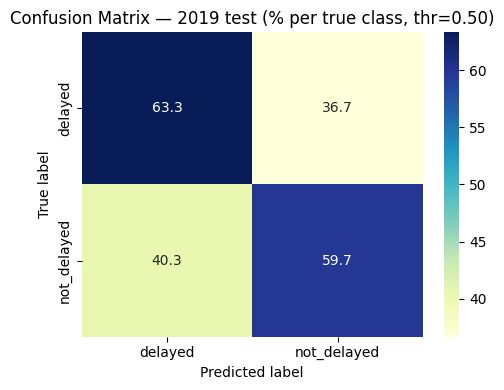

In [0]:
# Test with one layer
final_mlp_metrics_2019 = train_eval_mlp_full_train_vs_2019(
    train_df_all=train_df_all,
    test_2019_df=test_2019_df,
    label_col=label_col,
    numeric_cols=numeric_cols,
    categorical_cols=categorical_cols,
    hidden_layers=[32],       
    maxIter=50,
    blockSize=128,
    balance_train=True,
    maj_to_min_ratio=1.0,      
    threshold=0.5,            
)


=== Final MLP: train on 2015–2018, test on 2019 ===
Training MLP: layers=[323, 64, 32, 2], maxIter=50, blockSize=128


/databricks/spark/python/pyspark/sql/context.py:165: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(



--- Final metrics for 'delayed' (threshold=0.50) ---
TRAIN (2015–2018 balanced, ratio=1.2): P=0.5945, R=0.5574, F1=0.5753
TEST  (2019 blind): P=0.2765, R=0.5279, F1=0.3629
Times: feature_fit=16.0s, train=229.1s, eval=0.1s

Plotting confusion matrix for 2019 (blind test, % per true class)...


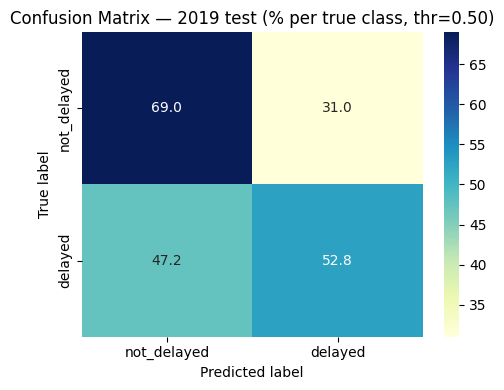

In [0]:
# Test with 2 layers
final_mlp_metrics_2019 = train_eval_mlp_full_train_vs_2019(
    train_df_all=train_df_all,
    test_2019_df=test_2019_df,
    label_col=label_col,
    numeric_cols=numeric_cols,
    categorical_cols=categorical_cols,
    hidden_layers=[64, 32],       
    maxIter=50,
    blockSize=128,
    balance_train=True,
    maj_to_min_ratio=1.2,      
    threshold=0.5,            
)


=== Final MLP: train on 2015–2018, test on 2019 ===
Training MLP: layers=[323, 128, 64, 32, 2], maxIter=50, blockSize=128


/databricks/spark/python/pyspark/sql/context.py:165: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(



--- Final metrics for 'delayed' (threshold=0.50) ---
TRAIN (2015–2018 balanced, ratio=1.2): P=0.5939, R=0.5296, F1=0.5599
TEST  (2019 blind): P=0.2731, R=0.5061, F1=0.3547
Times: feature_fit=16.1s, train=493.0s, eval=0.1s

Plotting confusion matrix for 2019 (blind test, % per true class)...


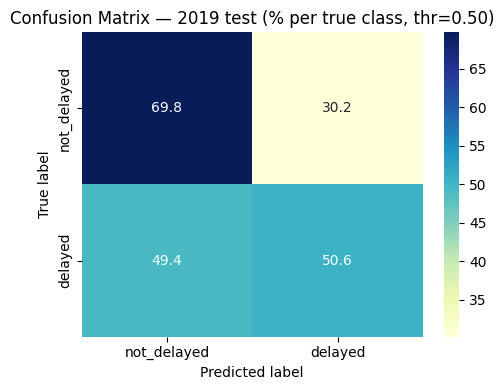

In [0]:
# Test with three layer
final_mlp_metrics_2019 = train_eval_mlp_full_train_vs_2019(
    train_df_all=train_df_all,
    test_2019_df=test_2019_df,
    label_col=label_col,
    numeric_cols=numeric_cols,
    categorical_cols=categorical_cols,
    hidden_layers=[128, 64, 32],       
    maxIter=50,
    blockSize=128,
    balance_train=True,
    maj_to_min_ratio=1.2,       
    threshold=0.5,            
)